# SHAP

## Import, Download (FIRST THING TO DO)

In [ ]:
# in conda env
# shap, cv2, matplotlib, tensorflow install

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import shap

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input

/home/jiheeyou/.conda/envs/disc/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-10-04 12:03:40.245406: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-04 12:03:40.245539: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-04 12:03:40.247941: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-04 12:03:40.485798: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow 

In [3]:
truemean = pd.read_csv('attribute_means.csv')

In [4]:
def true_mean(stim):
  stim = int(stim)
  return truemean["happy"][stim-1] # For i+1.jpg, should look for truemean['happy'][i]

## Alfred's Resnet50 (Pre-Trained)

In [5]:
# Load the ResNet50 model with given input shape and without the top (fully-connected) layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(1024,1024,3))

# Freeze all the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add a global spatial average pooling layer
x = GlobalAveragePooling2D()(base_model.output)

# Add a fully-connected layer with 1 neuron
predictions = Dense(1)(x)

# Construct the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Load the weights for the last two layers from the HDF5 file
model.load_weights('checkpoints/wrwf.hdf5', by_name=True)

2023-10-04 12:03:46.802325: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-10-04 12:03:46.802393: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: aa001
2023-10-04 12:03:46.802409: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: aa001
2023-10-04 12:03:46.802566: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: NOT_FOUND: was unable to find libcuda.so DSO loaded into this program
2023-10-04 12:03:46.802617: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 535.54.3


## SHAP plot

In [13]:
print('Hello world')

Hello world


In [17]:
def preprocess_image(image_path, target_size=(1024, 1024)):
    """(1024,1024,3) is the shape after this block"""
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)

    """(1,1024,1024,3) is the shape after this block"""
    img_array = np.expand_dims(img_array, axis=0)

    # Normalize the image
    img_array /= 255.0
    return img_array
preprocess_image(image_path)

(1024, 1024, 3)
(1, 1024, 1024, 3)


array([[[[0.6784314 , 0.7019608 , 0.6627451 ],
         [0.67058825, 0.69411767, 0.654902  ],
         [0.654902  , 0.6862745 , 0.6431373 ],
         ...,
         [0.627451  , 0.6745098 , 0.63529414],
         [0.61960787, 0.6666667 , 0.627451  ],
         [0.6117647 , 0.65882355, 0.61960787]],

        [[0.6784314 , 0.7019608 , 0.6627451 ],
         [0.6627451 , 0.69411767, 0.6509804 ],
         [0.6509804 , 0.68235296, 0.6392157 ],
         ...,
         [0.6313726 , 0.6784314 , 0.6392157 ],
         [0.627451  , 0.6745098 , 0.63529414],
         [0.62352943, 0.67058825, 0.6313726 ]],

        [[0.67058825, 0.7019608 , 0.65882355],
         [0.65882355, 0.6901961 , 0.64705884],
         [0.6509804 , 0.68235296, 0.6392157 ],
         ...,
         [0.6313726 , 0.6784314 , 0.6392157 ],
         [0.63529414, 0.68235296, 0.6431373 ],
         [0.6392157 , 0.6862745 , 0.64705884]],

        ...,

        [[0.45490196, 0.4745098 , 0.4509804 ],
         [0.45882353, 0.47843137, 0.45490196]

In [12]:
def f(X):
    tmp = X.copy()
    preprocess_input(tmp)
    return model(tmp)

def create_X():
    path = os.path.join('test_set/')
    X = []
    stimulus = []
    i=0
    for img in os.listdir(path):
      if i>=10:
        break
      else:
        try:
            img_array = cv2.imread(os.path.join(path, img))
            print(img_array.size)
            new_array = cv2.resize(img_array, (1024,1024)) # not reducing or magnifying. merely stacking
            X.append(new_array)  # Directly append the resized image to X
            stimulus.append(img[:-4])
            i+=1
        except Exception as e:
            print(f"Error processing image: {img}. Error: {e}")
    return np.array(X), stimulus  # Convert the list to a numpy array

X, stimulus = create_X()

3145728
3145728
3145728
3145728
3145728
3145728
3145728
3145728
3145728
3145728


In [9]:
stimulus

['972', '617', '887', '733', '856', '880', '734', '851', '909', '748']

In [16]:
mp = []
for s in stimulus:
    image_path = "test_set/"+s+".jpg"
    mp.append(model.predict(preprocess_image(image_path))[0,0])
mp

1/1 [==============================] - 2s 2s/step


[-0.924263,
 -0.9489759,
 -0.97857213,
 -0.9439059,
 -0.86643773,
 -0.9408406,
 -0.9365337,
 -0.9200756,
 -0.9283176,
 -0.96891123]

In [19]:
np.mean(mp)

-0.93568337

## Visualize images from test_set

In [10]:
def show_image(img_array):
    # Since we expanded dimensions for model input, we need to squeeze
    # the first dimension to visualize it.
    # The shape will change from (1, 1024, 1024, 3) to (1024, 1024, 3)
    img_array = np.squeeze(img_array, axis=0)
    plt.imshow(img_array)
    plt.axis('off')  # To hide the axis values
    plt.show()

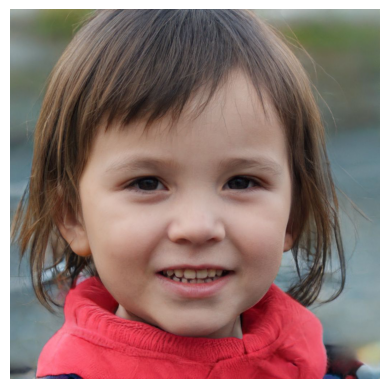

1/1 [==============================] - 5s 5s/step


array([[82.085754]], dtype=float32)

In [11]:
# Visualize the processed_image
image_path = "test_set/1004.jpg"
prim = preprocess_image(image_path)
show_image(prim)
model.predict(prim)

# CURRENT

In [ ]:
# wrwf
# define a masker that is used to mask out partitions of the input image, this one uses a blurred background
masker = shap.maskers.Image("inpaint_telea", X[0].shape)

explainer = shap.Explainer(f, masker) #"output_names=class_names"

# here we use 500 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(X[2:3], max_evals=100, batch_size=25, outputs=shap.Explanation.argsort.flip[:1])
shap.image_plot(shap_values)

print(true_mean(stimulus[2]))
print(model.predict(prim))
print(shap_values.base_values)

 12%|█████▎                                     | 12/98 [00:27<03:19,  2.32s/it]

### Past Models

  0%|          | 0/498 [00:00<?, ?it/s]


Partition explainer: 2it [08:33, 513.42s/it]              


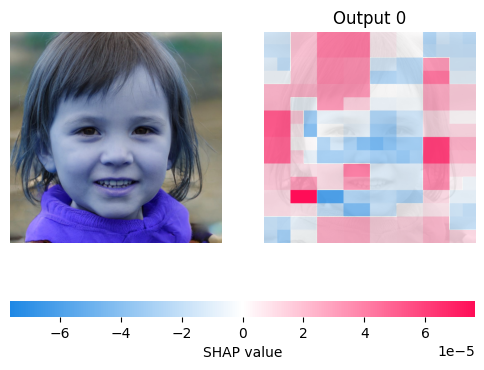

In [ ]:
# nrnf
# define a masker that is used to mask out partitions of the input image, this one uses a blurred background
masker = shap.maskers.Image("inpaint_telea", X[0].shape)

explainer = shap.Explainer(f, masker) #"output_names=class_names"

# here we use 500 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(X[1:2], max_evals=5000, batch_size=10, outputs=shap.Explanation.argsort.flip[:1])
shap.image_plot(shap_values)

In [ ]:
print(true_mean(stimulus[1]))
print(model.predict(prim))
print(shap_values.base_values)

63.47058824
1/1 [==============================] - 0s 46ms/step
[[110.91558]]
[[66.40772247]]


  0%|          | 0/498 [00:00<?, ?it/s]


Partition explainer: 2it [07:10, 430.58s/it]              


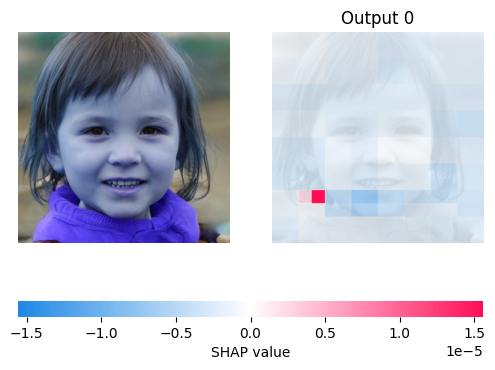

63.47058824
1/1 [==============================] - 1s 833ms/step
[[5.4906993]]
[[2.49875736]]


In [ ]:
# nrwf
# define a masker that is used to mask out partitions of the input image, this one uses a blurred background
masker = shap.maskers.Image("inpaint_telea", X[0].shape)

explainer = shap.Explainer(f, masker) #"output_names=class_names"

# here we use 500 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(X[1:2], max_evals=500, batch_size=20, outputs=shap.Explanation.argsort.flip[:1])
shap.image_plot(shap_values)

print(true_mean(stimulus[1]))
print(model.predict(prim))
print(shap_values.base_values)

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 2it [08:14, 494.09s/it]              


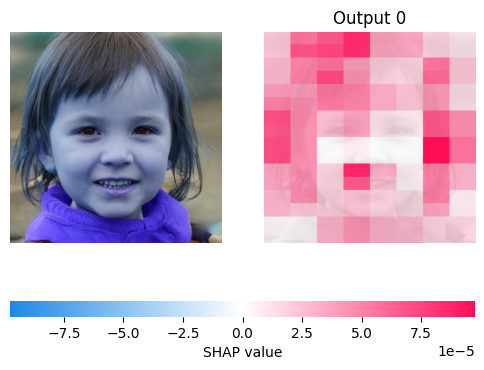

63.47058824
1/1 [==============================] - 0s 35ms/step
[[82.089035]]
[[36.49733353]]


In [ ]:
# wrwf
# define a masker that is used to mask out partitions of the input image, this one uses a blurred background
masker = shap.maskers.Image("inpaint_telea", X[0].shape)

explainer = shap.Explainer(f, masker) #"output_names=class_names"

# here we use 500 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(X[1:2], max_evals=500, batch_size=25, outputs=shap.Explanation.argsort.flip[:1])
shap.image_plot(shap_values)

print(true_mean(stimulus[1]))
print(model.predict(prim))
print(shap_values.base_values)

### New Models

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 2it [08:03, 483.52s/it]              


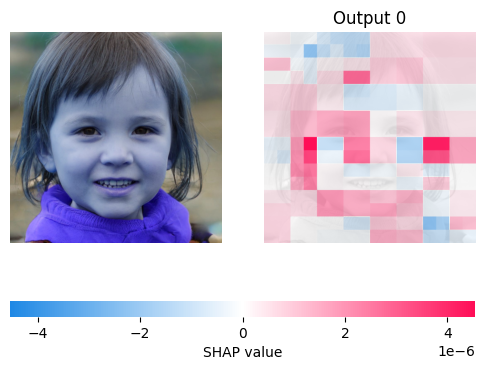

63.47058824
1/1 [==============================] - 1s 860ms/step
[[1.208514]]
[[-0.92152691]]


In [ ]:
# wrnf
# define a masker that is used to mask out partitions of the input image, this one uses a blurred background
masker = shap.maskers.Image("inpaint_telea", X[0].shape)

explainer = shap.Explainer(f, masker) #"output_names=class_names"

# here we use 500 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(X[1:2], max_evals=500, batch_size=25, outputs=shap.Explanation.argsort.flip[:1])
shap.image_plot(shap_values)

print(true_mean(stimulus[1]))
print(model.predict(prim))
print(shap_values.base_values)

# Past

## Preprocess OMI, models

In [ ]:
class_names = {
    0: 'not happy',
    1: 'happy'}

In [ ]:
binary_labels = np.load('young_y.npy')
data_directory = "young100/"
img_size = 224

training_data = []

def create_training_data():
  n = 0
  for img in os.listdir(data_directory):
    n+=1
    try:
      img_array = cv2.imread(os.path.join(data_directory, img))
      new_array = cv2.resize(img_array, (img_size, img_size))
      training_data.append([new_array, binary_labels[n-1]])
    except Exception as e:
      print(f"Error processing image: {os.path.join(data_directory, img)} - {e}")

create_training_data()
random.shuffle(training_data)

X = []
y = []
for features, label in training_data:
  X.append(features)
  y.append(label)
X = np.array(X).reshape(-1, img_size, img_size, 3)
# 3 is the channel for RGB
X = np.array(X).astype(np.float32) / 255.0  # Convert X to numpy array and normalize pixel values
y = np.array(y)

print(len(training_data))
print(X.shape)
print(len(y))

100
(100, 224, 224, 3)
100


In [ ]:
model = tf.keras.applications.MobileNetV2()
base_input = model.layers[0].input
base_output = model.layers[-2].output
final_output = layers.Dense(128)(base_output)
final_output = layers.Activation('relu')(final_output)
final_output = layers.Dense(64)(final_output)
final_output = layers.Activation('relu')(final_output)
final_output = layers.Dense(2, activation='softmax')(final_output)
new_model = keras.Model(inputs = base_input, outputs = final_output)
new_model.compile(loss='sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
new_model.fit(X, y, epochs = 10)

14536120/14536120 [==============================] - 0s 0us/step
Epoch 1/10


KeyboardInterrupt: ignored

In [ ]:
new_model.save('omi_young100.h5')

## Load OMI model

In [ ]:
loaded_model = keras.models.load_model('/content/drive/My Drive/omi_young100.h5')

In [ ]:
img_size = 224

sample_data = []

def create_sample_data():
    path = os.path.join('/content/drive//My Drive/age_sample_gan/')
    for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path, img))
            new_array = cv2.resize(img_array, (img_size, img_size))
            sample_data.append([new_array])
        except:
            print(f"Error processing image: {img}")

create_sample_data()

X_sample = []
for features in sample_data:
    X_sample.append(features)
X_sample = np.array(X_sample).reshape(-1, img_size, img_size, 3)
X_sample = X_sample.astype(np.float32) / 255.0  # Convert X to numpy array and normalize pixel values
print(X_sample.shape)

(3, 224, 224, 3)


In [ ]:
# python function to get model output; replace this function with your own model function.
def f(x):
    tmp = x.copy()
    preprocess_input(tmp)
    return loaded_model(tmp)

# define a masker that is used to mask out partitions of the input image.
masker_blur = shap.maskers.Image("blur(128,128)", X_sample[0].shape)

# create an explainer with model and image masker
explainer_blur = shap.Explainer(f, masker_blur, output_names=[0,1])

# here we explain two images using 500 evaluations of the underlying model to estimate the SHAP values
shap_values_fine = explainer_blur(X_sample, max_evals=5000, batch_size=50, outputs=shap.Explanation.argsort.flip[:2])

  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer:  33%|███▎      | 1/3 [00:00<?, ?it/s]

  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 100%|██████████| 3/3 [00:46<00:00, 11.35s/it]

  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 4it [01:10, 23.35s/it]


In [ ]:
loaded_model.predict(X_sample)

1/1 [==============================] - 1s 1s/step


array([[0.264453  , 0.73554707],
       [0.47004327, 0.5299567 ],
       [0.6032262 , 0.39677382]], dtype=float32)

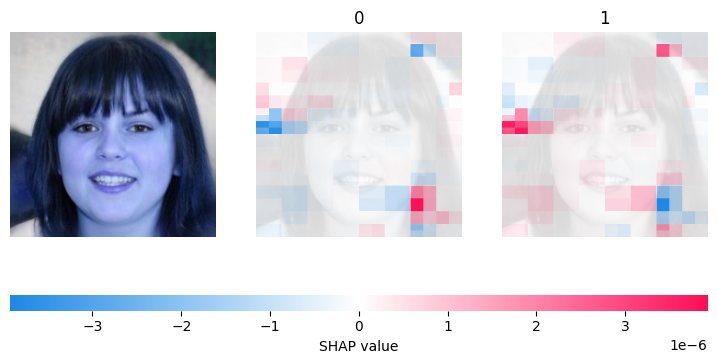

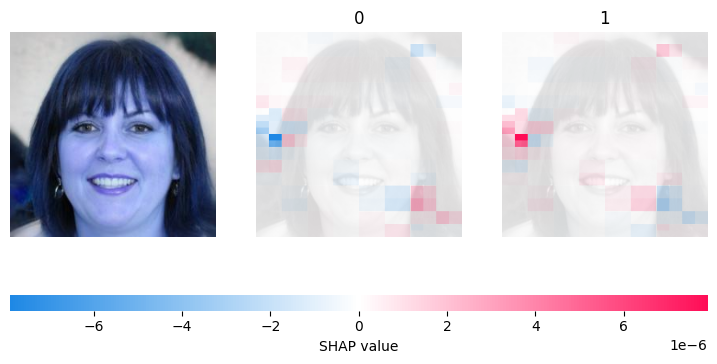

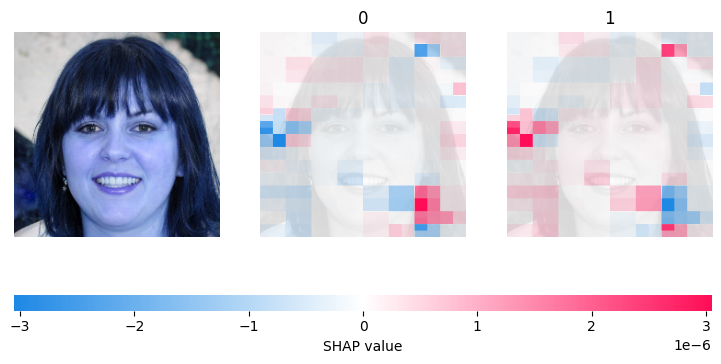

In [ ]:
# Plot the SHAP values, young100
for i in range(len(X_sample)):
  shap.image_plot(shap_values_fine[i])

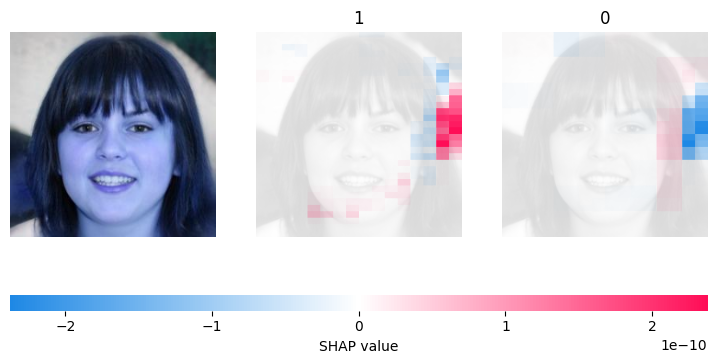

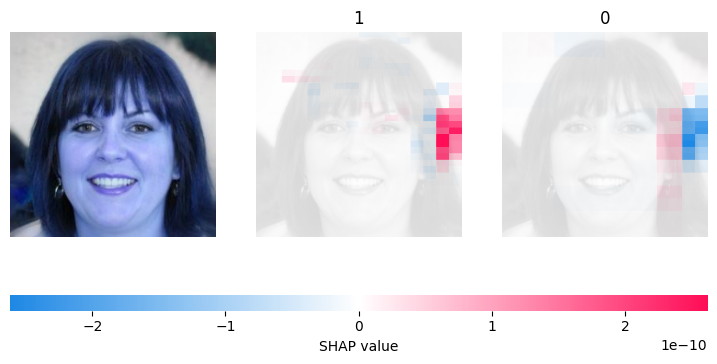

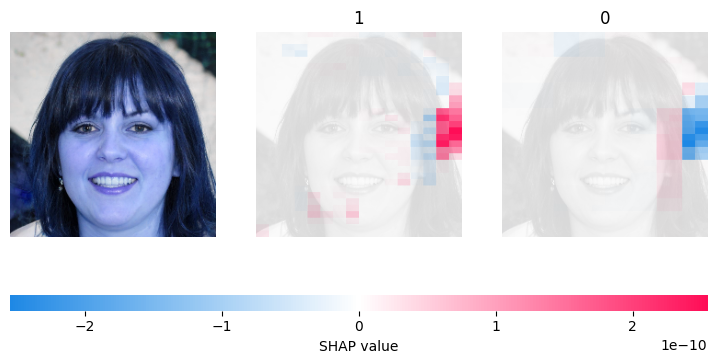

In [ ]:
# Plot the SHAP values, random100
for i in range(len(X_sample)):
  shap.image_plot(shap_values_fine[i])

## Preprocess (fer2013)

Main code reference on creating a tensorflow model:
https://medium.com/analytics-vidhya/realtime-face-emotion-recognition-using-transfer-learning-in-tensorflow-3add4f4f3ff3

In [ ]:
data_directory = "random100/"
classes = [0, 1, 2, 3, 4, 5, 6]

class_names = {
    0: 'angry',
    1: 'disgust',
    2: 'fear',
    3: 'happy',
    4: 'sad',
    5: 'surprise',
    6: 'neutral'
}

In [ ]:
img_size = 224

training_data = []

def create_training_data():
  for category in class_names:
    path = os.path.join(data_directory, class_names[category])
    class_num = category
    for img in os.listdir(path):
      try:
        img_array = cv2.imread(os.path.join(path, img))
        new_array = cv2.resize(img_array, (img_size, img_size))
        training_data.append([new_array, class_num])
      except Exception as e:
        print(f"Error processing image: {os.path.join(path, img)} - {e}")

create_training_data()
random.shuffle(training_data)

In [ ]:
X = []
y = []
for features, label in training_data:
  X.append(features)
  y.append(label)
X = np.array(X).reshape(-1, img_size, img_size, 3)
# 3 is the channel for RGB
X = np.array(X).astype(np.float32) / 255.0  # Convert X to numpy array and normalize pixel values
y = np.array(y)

In [ ]:
print(len(training_data))
print(X.shape)
print(len(y))

7178
(7178, 224, 224, 3)
7178


In [ ]:
save_path = '/content/drive/My Drive/X.npy'
np.save(save_path, X)

In [ ]:
save_path = '/content/drive/My Drive/y.npy'
np.save(save_path, y)

## Model (fer2013 2700 images)
Retried on 3000+, failed

In [ ]:
# Load X and y from the .npy files
X = np.load('X.npy')
y = np.load('y.npy')

print(X.shape)
print(len(y))

(7178, 224, 224, 3)
7178


In [ ]:
model = tf.keras.applications.MobileNetV2()
base_input = model.layers[0].input
base_output = model.layers[-2].output
final_output = layers.Dense(128)(base_output)
final_output = layers.Activation('relu')(final_output)
final_output = layers.Dense(64)(final_output)
final_output = layers.Activation('relu')(final_output)
final_output = layers.Dense(7, activation='softmax')(final_output)
new_model = keras.Model(inputs = base_input, outputs = final_output)
new_model.compile(loss='sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
new_model.fit(X, y, epochs = 20)

14536120/14536120 [==============================] - 1s 0us/step
Epoch 1/20


KeyboardInterrupt: ignored

In [ ]:
new_model.save('fer2013test_20epochs.h5')

## Load model

In [ ]:
loaded_model = keras.models.load_model('/content/drive/My Drive/Final_model_95p07.h5')

In [ ]:
classes = [0, 1, 2, 3, 4, 5, 6]
img_size = 224

sample_data = []

def create_sample_data():
    path = os.path.join('/content/drive//My Drive/single_sample_gan/')
    for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path, img))
            new_array = cv2.resize(img_array, (img_size, img_size))
            sample_data.append([new_array])
        except:
            print(f"Error processing image: {img}")

create_sample_data()

X_sample = []
for features in sample_data:
    X_sample.append(features)
X_sample = np.array(X_sample).reshape(-1, img_size, img_size, 3)
X_sample = X_sample.astype(np.float32) / 255.0  # Convert X to numpy array and normalize pixel values

In [ ]:
# python function to get model output; replace this function with your own model function.
def f(x):
    tmp = x.copy()
    preprocess_input(tmp)
    return loaded_model(tmp)

# define a masker that is used to mask out partitions of the input image.
masker_blur = shap.maskers.Image("blur(128,128)", X_sample[0].shape)

# create an explainer with model and image masker
explainer_blur = shap.Explainer(f, masker_blur, output_names=classes)

# here we explain two images using 500 evaluations of the underlying model to estimate the SHAP values
shap_values_fine = explainer_blur(X_sample, max_evals=5000, batch_size=50, outputs=shap.Explanation.argsort.flip[:7])

  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer:  14%|█▍        | 1/7 [00:00<?, ?it/s]

  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer:  43%|████▎     | 3/7 [10:44<09:55, 148.98s/it]

  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer:  57%|█████▋    | 4/7 [15:34<10:23, 207.77s/it]

  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer:  71%|███████▏  | 5/7 [20:33<08:03, 241.82s/it]

  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer:  86%|████████▌ | 6/7 [25:21<04:18, 258.08s/it]

  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 100%|██████████| 7/7 [30:15<00:00, 269.78s/it]

  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 8it [35:05, 300.84s/it]


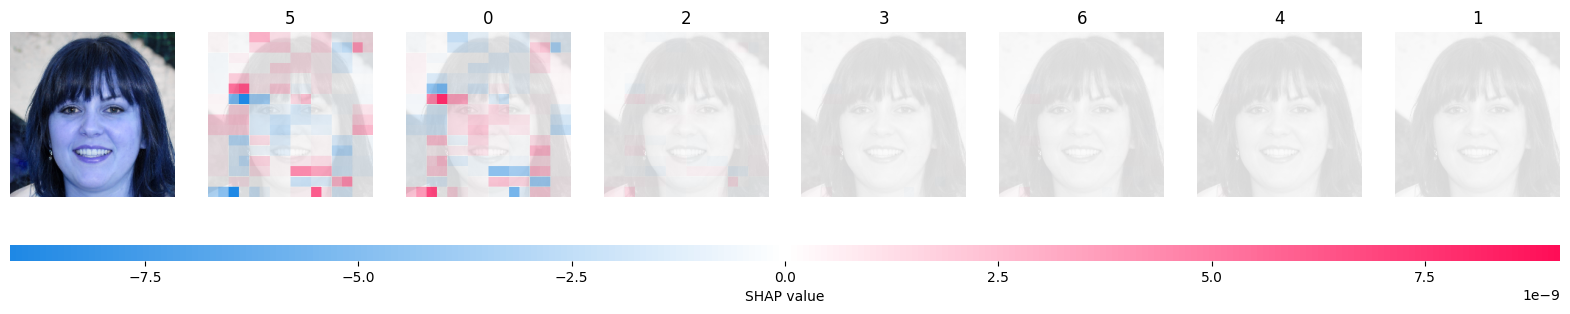

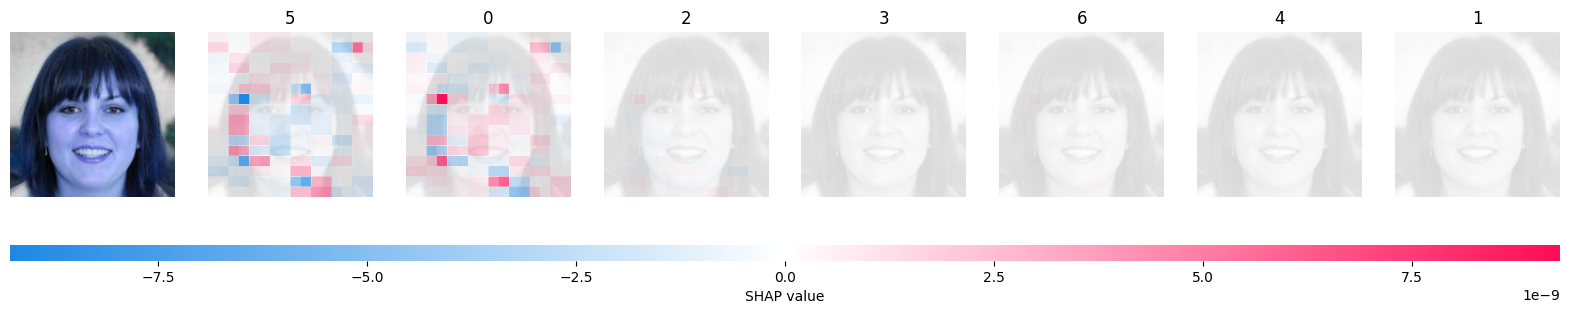

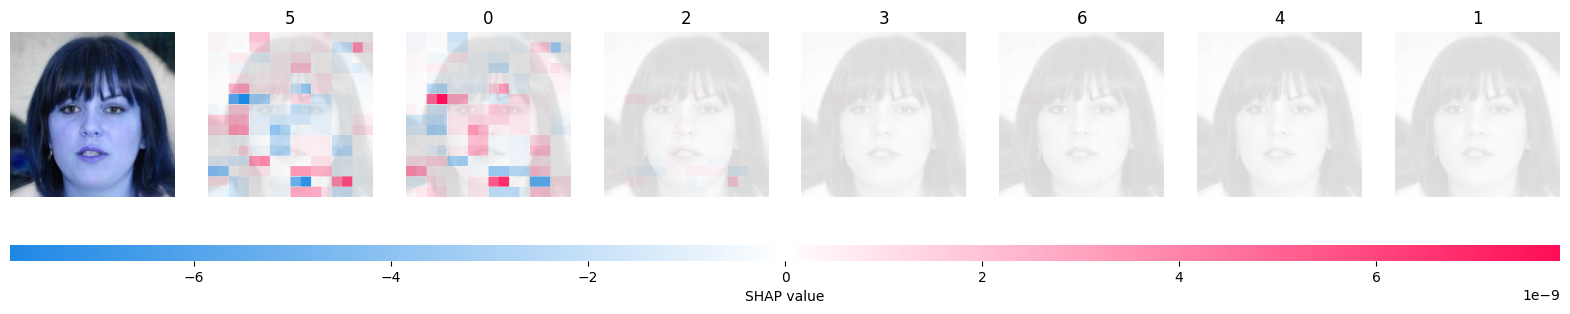

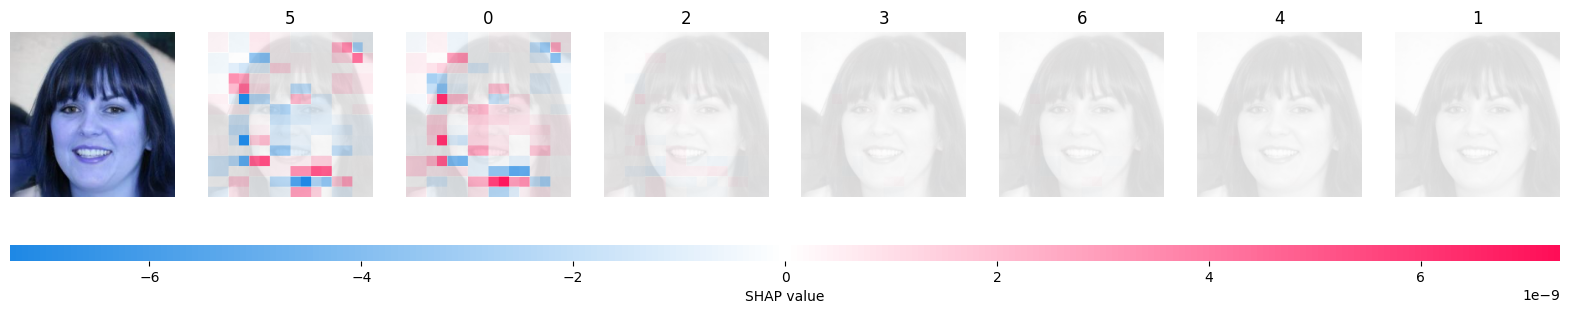

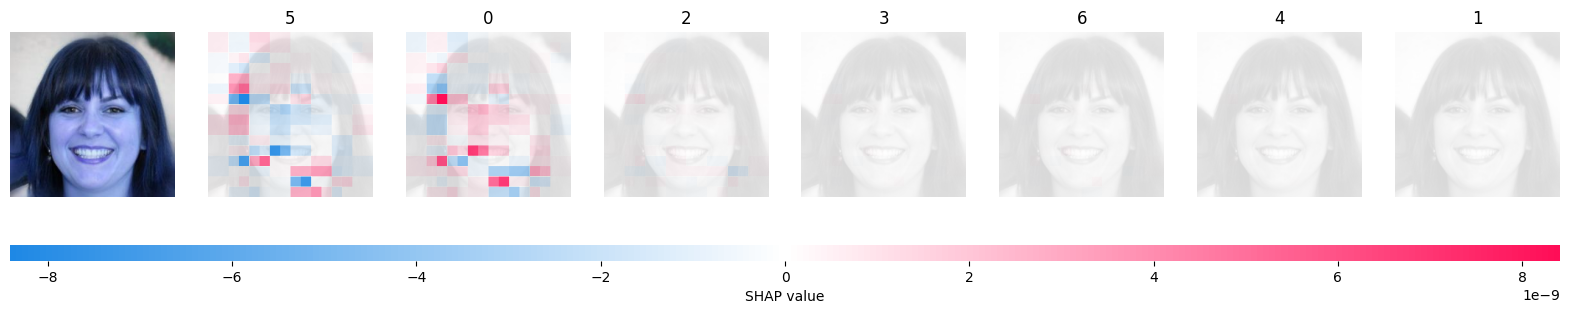

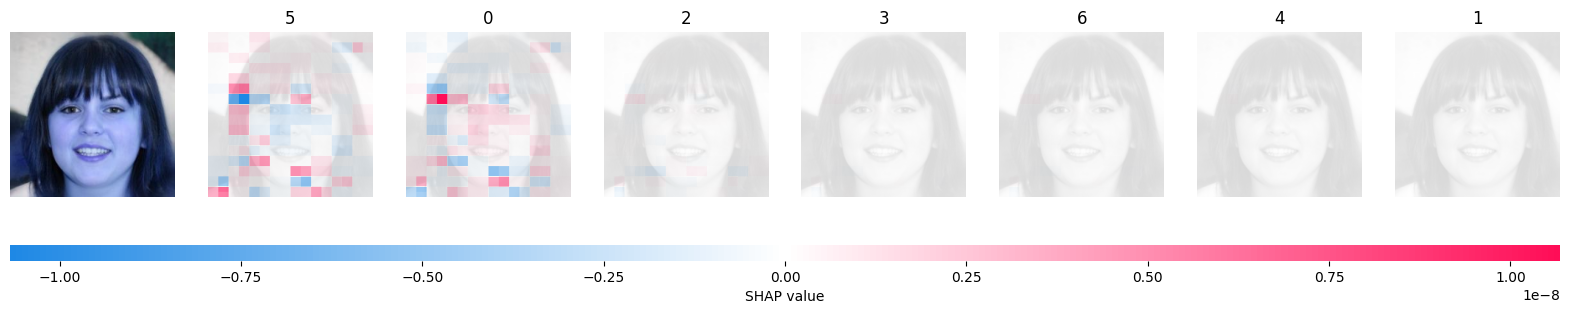

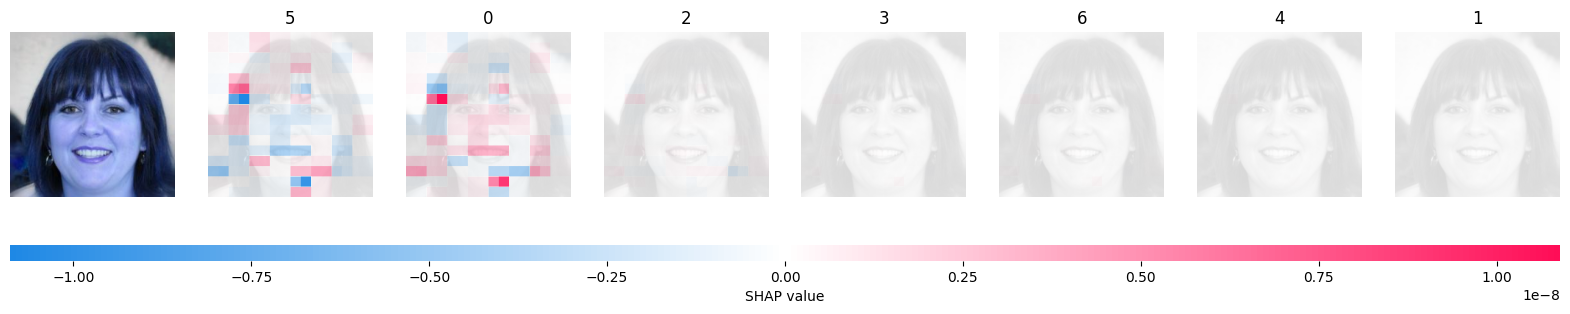

In [ ]:
# Plot the SHAP values, fer2013 model
for i in range(len(X_sample)):
  shap.image_plot(shap_values_fine[i])

In [ ]:
save_path = '/content/drive/My Drive/shap_values_fine.npy'
np.save(save_path, shap_values_fine)

## Previous Visualizations

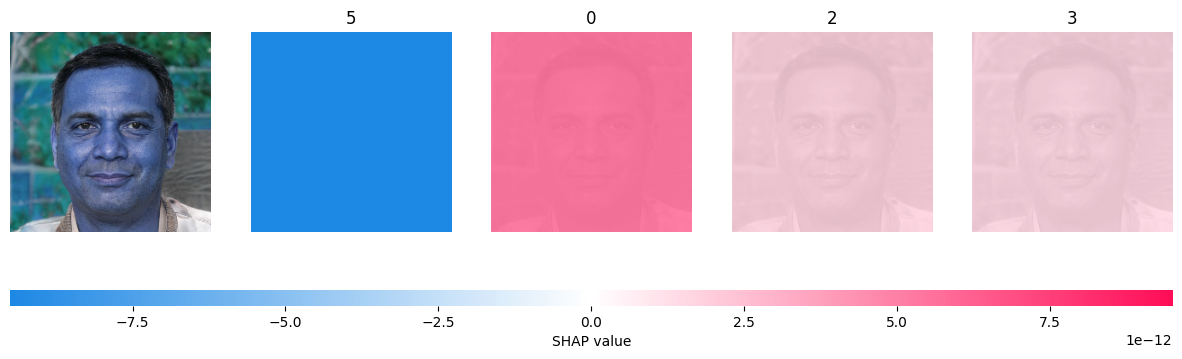

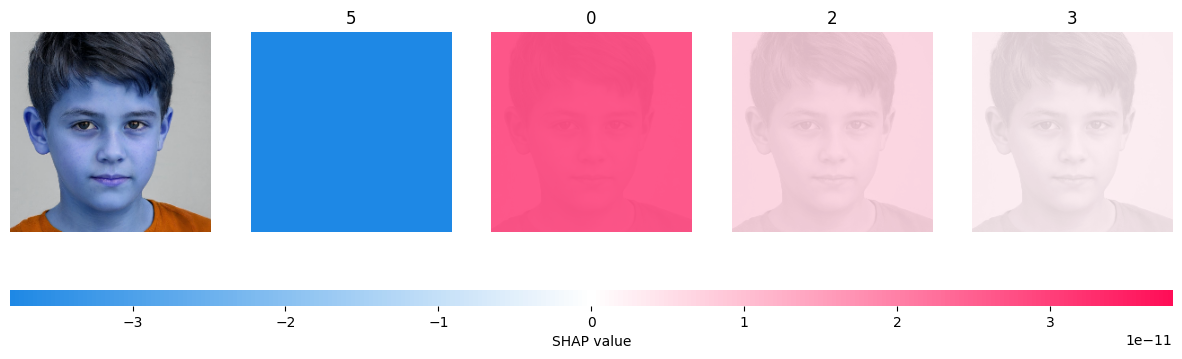

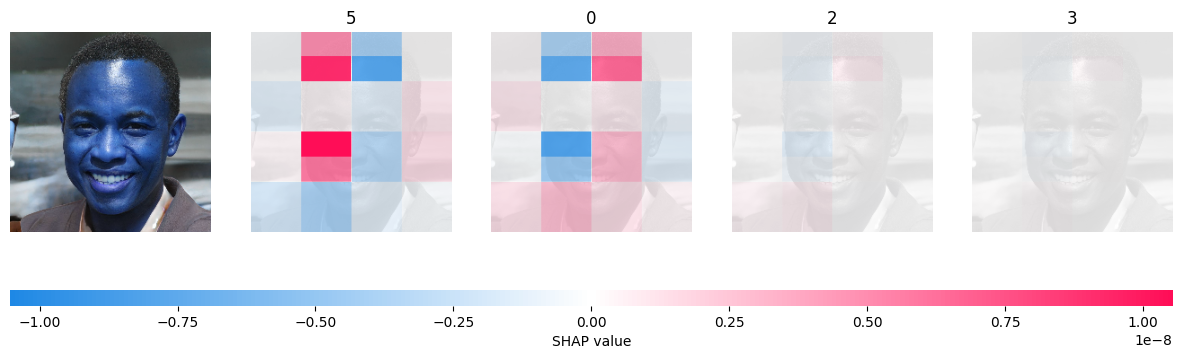

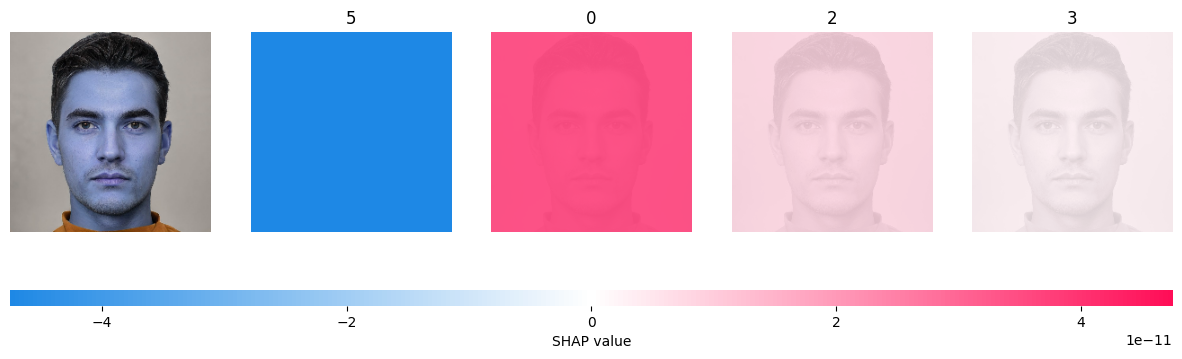

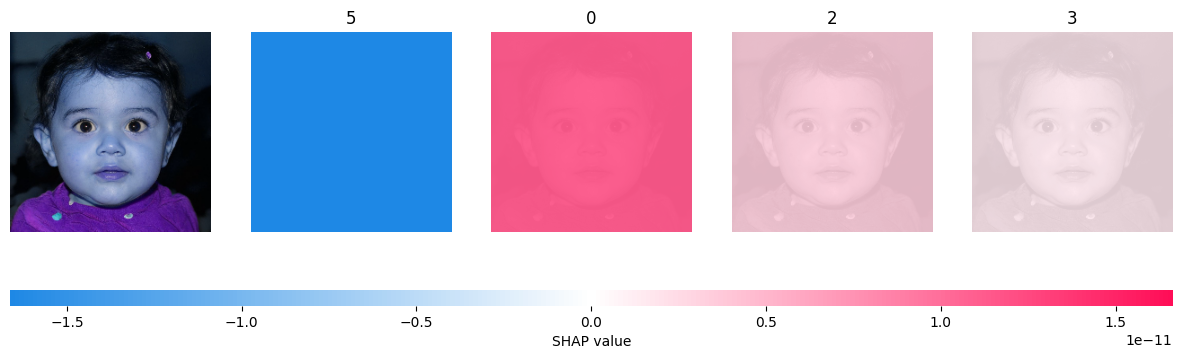

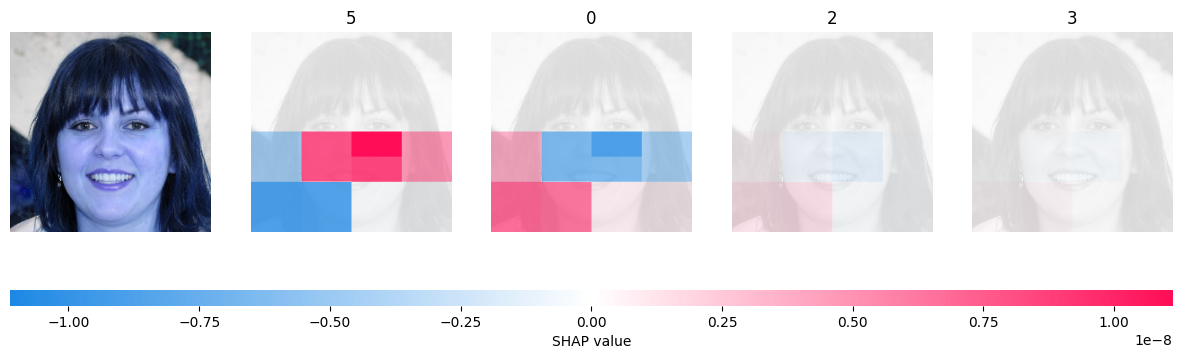

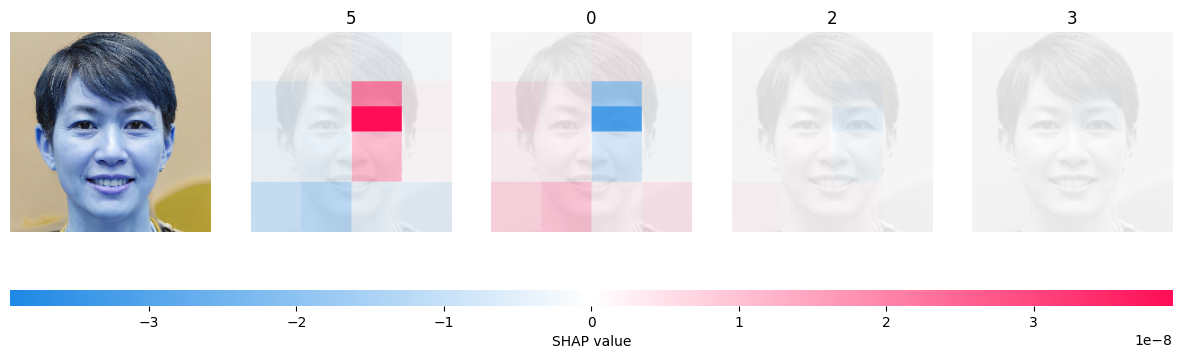

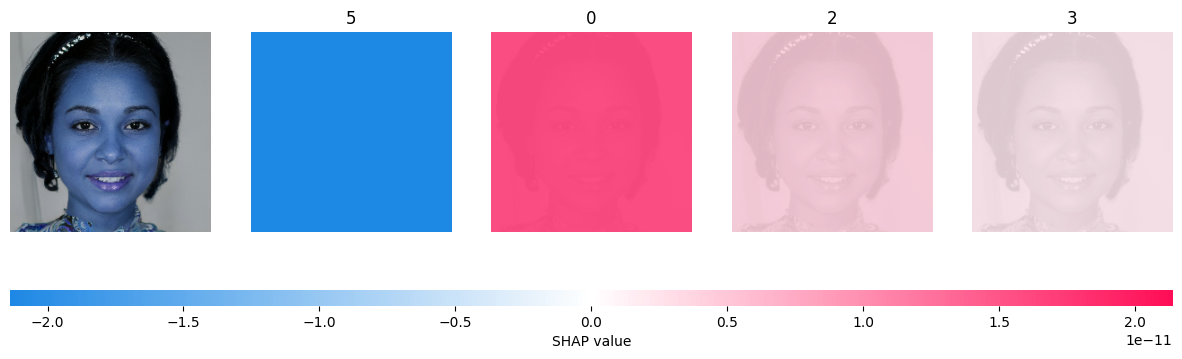

In [ ]:
# Few images from OMI
for i in range(len(X_sample)):
  shap.image_plot(shap_values[i])